# Deploying Your Model on Kubernetes

After building and optimizing your model, you may then want to operationalize your model. In this notebook, we'll show you how to deploy your model onto a Kubernetes cluster.

We will walk through the following steps:
1. Load a saved model locally to check that it loads correctly
1. Setup your deployment by uploading your models, creating your scoring script and setting up your deployment environment
1. Create a Kubernetes cluster and deploy your model
1. Test that your deployed model works.

> NOTE: this notebook assumes that you've already run the 01_training_introduction notebook since it uses the saved model that is created in that notebook.

If you've gone through the [classification deployment notebooks](../classification/22_deployment_on_azure_kubernetes_service.ipynb), you'll notice that this deployment notebook looks quite different. The main difference is that this notebook demonstrates how to deploy your model in one concise way and relies on Azure ML's docker creation process, while the deployment notebooks under the classification scenarios demonstrates in much more detail the nuances when it comes to deployment, and all the different bells and whistles that Azure ML offers.

For a much more detailed deployment solution, visit the [deployment scenario](https://docs.microsoft.com/en-us/azure/architecture/reference-architectures/ai/realtime-scoring-python) in the Azure Architecture Center for a full end-to-end tutorial on deploying a model to Azure Kubernetes. 

In [75]:
import sys
sys.path.append("../../")

import os
from PIL import Image
from pathlib import Path
import requests
import json
import inspect

from utils_cv.common.image import ims2strlist
from utils_cv.common.data import data_path
from utils_cv.detection.model import DetectionLearner, get_pretrained_fasterrcnn
from utils_cv.detection.dataset import DetectionDataset
from utils_cv.detection.plot import (
    display_bboxes,
    PlotSettings,
    DetectionBbox
)
from utils_cv.common.azureml import get_or_create_workspace

from azureml.core.webservice import AksWebservice
from azureml.core.compute import AksCompute, ComputeTarget
from azureml.core.model import Model, InferenceConfig

Ensure edits to libraries are loaded and plotting is shown in the notebook.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

To create or access an Azure ML Workspace, you will need the following information:

- <b>subscription ID:</b> the ID of the Azure subscription we are using
- <b>resource group:</b> the name of the resource group in which our workspace resides
- <b>workspace region:</b> the geographical area in which our workspace resides (e.g. "eastus2" -- other examples are available [here](https://azure.microsoft.com/en-us/global-infrastructure/geographies/) <i>-- note the lack of spaces</i>)
- <b>workspace name:</b> the name of the workspace we want to create or retrieve.

Note: As with other Azure services, there are limits on certain resources like cluster size associated with the Azure Machine Learning service. Please read [this](https://docs.microsoft.com/en-us/azure/azure-subscription-service-limits) article on the default limits and how to request more quota.

If you have a workspace created already, you need to get your subscription and workspace information. You can find the values for those by visiting your workspace in the Azure portal. If you don't have a workspace, the create workspace command in the next section will create a resource group and a workspace using the names you provide.

In [ ]:
# Azure resources
subscription_id = "YOUR_SUBSCRIPTION_ID"
resource_group = "YOUR_RESOURCE_GROUP_NAME"  
workspace_name = "YOUR_WORKSPACE_NAME"  
workspace_region = "YOUR_WORKSPACE_REGION"

# Choose a size for our cluster and the maximum number of nodes
VM_SIZE = "STANDARD_NC6" #STANDARD_NC6S_V3"
NODES = 3
KUBERNETES_CLUSTER_NAME = "od-aks-cluster"
DEPLOYMENT_SERVICE_NAME = "drink-detector"
MODEL_NAME = "drink-detector"

# Load a saved model

When we deploy our model, we want our deployed model to inference new images. To do this, we need to make sure that our model has all the information it needs perform inferencing. We can use the load/save functionality under `utils_cv.detection.model` to do this.

Loading the model will regenerate a `DetectionLearner` based on the `model.pt` and the `meta.json` files. Once the model is re-created, we can simply call its `predict` function to perform inferecing on new images.

Before we create our deployment, lets make sure that we are able to load a saved model locally. 

After running the `01_training_introduction` notebook, we should have a saved model in our data folder. Lets check:

In [3]:
[print(f) for f in Path(data_path()/"odFridgeObjects"/"models").glob('**/*')]

/home/jiata/code/computervision/data/odFridgeObjects/models/my_drink_detector
/home/jiata/code/computervision/data/odFridgeObjects/models/my_drink_detector/meta.json
/home/jiata/code/computervision/data/odFridgeObjects/models/my_drink_detector/model.pt


[None, None, None]

We see that under the `models` folder, there is a folder called `my_drink_detector` that contains the `meta.json` and the `model.pt` files. Lets create a `DetectionLearner` using the `from_saved_model` function.

In [4]:
detector = DetectionLearner.from_saved_model(name="my_drink_detector", path=data_path()/"odFridgeObjects"/"models")

Lets test that we can run `predict` on this new `DetectionLearner`. Lets chose some random image from our folder and run it through the predict function:

In [5]:
rand_im_path = Path(data_path()/"odFridgeObjects"/"images"/"1.jpg")
rand_im = Image.open(rand_im_path)
detections = detector.predict(rand_im, threshold=0.5)

Lets plot the results to make sure it looks right.

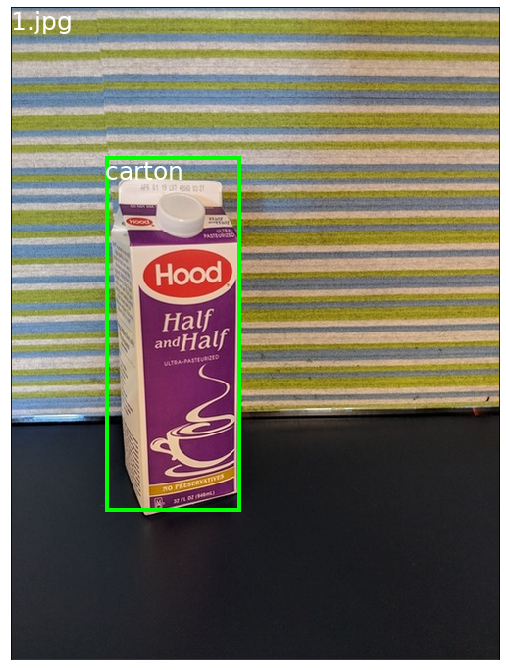

In [6]:
plot_settings = PlotSettings(rect_color=(0, 255, 0))
display_bboxes(
    detections,
    rand_im_path,
    plot_settings=plot_settings,
)

# Setup your deployment

Now that we know how to load a saved model, lets use this to create a `DetectionLearner` in a Docker container. We'll perform the following steps:
1. Setup our Azure ML Workspace
1. Upload our model files to Azure ML
1. Create the scoring script
1. Create a conda environment



## Setup Azure ML Workspace

This cell will create an AML workspace for you in a subscription, if one does not exist already, provided you have the correct permissions.

This will fail when:
- You do not have permission to create a workspace in the resource group
- You do not have permission to create a resource group if it's non-existing.
- You are not a subscription owner or contributor and no Azure ML workspaces have ever been created in this subscription
- If workspace creation fails, please work with your IT admin to provide you with the appropriate permissions or to provision the required resources. If this cell succeeds, you're done configuring AML!

In [ ]:
ws = get_or_create_workspace(
    subscription_id, resource_group, workspace_name, workspace_region
)

# Print the workspace attributes
print(
    "Workspace name: " + ws.name,
    "Workspace region: " + ws.location,
    "Subscription id: " + ws.subscription_id,
    "Resource group: " + ws.resource_group,
    sep="\n",
)

## Upload the Model files

We need to upload both the `meta.json` and `model.pt` that is required to re-create the `DetectionLearner`. We can do this by [registering](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-deploy-existing-model#register-the-models) the model files.

In [9]:
model_state_dict = Model.register(
    model_path=os.path.join(
        data_path(), "odFridgeObjects", "models", "my_drink_detector", "model.pt"
    ),
    model_name=f"{MODEL_NAME}-state-dict",
    tags={"Model": "object_detection_state_dict"},
    description="state dict for drink detector",
    workspace=ws,
)

model_meta = Model.register(
    model_path=os.path.join(
        data_path(), "odFridgeObjects", "models", "my_drink_detector", "meta.json"
    ),
    model_name=f"{MODEL_NAME}-meta",
    tags={"Model": "object_detection_meta"},
    description="meta data for drink detector",
    workspace=ws,
)

Registering model jiata-dd-model-state-dict-0
Registering model jiata-dd-model-meta-0


Once the files are uploaded, we can go into the Azure portal (portal.azure.com) to see that your model files are there. Click into your Azure ML workspace and look under the 'models' tab to see that your registered models.


## Create scoring script

For the web service to return predictions on a given input image, we need to provide it with instructions on how to use the model we just registered. These instructions are stored in the scoring script.

This script must contain two required functions, `init()` and `run(input_data)`:
- In the `init()` function, we typically load the model into a global object. This function is executed only once when the Docker container is started.
- In the `run(input_data)` function, the model is used to predict a value based on the input data. The input and output of `run` typically use JSON as serialization and de-serialization format but we are not limited to that.

Using the notation `%%writefile` we store this file in the current directory.

In [10]:
scoring_script = "score.py"

In [11]:
%%writefile $scoring_script
# Copyright (c) Microsoft. All rights reserved.
# Licensed under the MIT license.

import os
import json
import shutil

from pathlib import Path
from base64 import b64decode
from io import BytesIO
from PIL import Image

from azureml.core.model import Model
from utils_cv.detection.model import DetectionLearner, get_pretrained_fasterrcnn
from utils_cv.detection.dataset import DetectionDataset


def init():
    global detector
    
    # retrieve the path to the model file using the model name
    model_state_dict_path = Model.get_model_path(model_name="drink-detector-state-dict")
    model_meta_data_path = Model.get_model_path(model_name="drink-detector-meta")
    # NOTE, for the 'model name', we can't use the parameter "MODEL_NAME" since we're writing to an external file

    # put model.pt and meta.json into the same folder
    model_dir = "new_detector"
    os.mkdir(model_dir)
    shutil.copyfile(model_state_dict_path, os.path.join(os.getcwd(), model_dir, "model.pt"))
    shutil.copyfile(model_meta_data_path, os.path.join(os.getcwd(), model_dir, "meta.json"))
    
    # load up the model
    detector = DetectionLearner.from_saved_model(name=model_dir, path=Path(os.getcwd()))


def run(raw_data):
    # Expects raw_data to be a list within a json file
    results = []    
    for im_string in json.loads(raw_data)['data']:
        im_bytes = b64decode(im_string)
        im_dets = []
        try:
            new_im = Image.open(BytesIO(im_bytes))
            detections = detector.predict(new_im, threshold=0.5)
            for d in detections:
                im_dets.append({
                    "top": str(d.top), 
                    "left": str(d.left),
                    "bottom": str(d.bottom), 
                    "right": str(d.right),
                    "label_name": d.label_name,
                    "label_idx": str(d.label_idx),
                    "score": str(d.score)
                })
        except Exception as e:
            im_dets.append({"error": str(e)})
        results.append(im_dets)
    return results

Overwriting score.py


## Setup the Conda Environment

Next we setup our docker image. This image will contain the scoring script we just created and have access to the model files that we registered. However, to setup the docker image, we need to define the conda environment that it will use. To do so, we create an environment yaml that we will pass into the docker configuration:

In [23]:
%%writefile "myenv.yml"
name: cv-remote
channels:
- defaults
- conda-forge
dependencies:
- python==3.6.8
- pytorch>=1.2.0
- torchvision>=0.3.0
- cython>=0.29.1
- git
- pip:
  - azureml-defaults==1.0.65
  - git+https://github.com/microsoft/ComputerVision.git@master
  - git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI

Overwriting myenv.yml


---

# Deploy the model to Kubernetes

In this section, we will create a Kubernetes cluster to deploy our model to. We will do the following steps:

1. Create a Kubernetes cluster
1. Specify the deployment settings
1. Make a deployment to the cluster

## Create a Kubernetes Cluster

We can choose between a CPU-based or a GPU-based cluster. The latter is typically better suited for web services with high traffic (i.e. &gt 100 requests per second) and high GPU utilization. 

- Standard D3 V2:
  - 4 vCPUs
  - 14 GB of memory


- Standard NC6:
  - 1 GPU
  - 12 GB of GPU memory
  - These machines also have 6 vCPUs and 56 GB of memory.

The following code will provision your Kubernetes cluster if it does not yet exist, or will retrieve your cluster if it already exists.

> NOTE: This command may take up to 20 minutes

In [28]:
if KUBERNETES_CLUSTER_NAME not in ws.compute_targets:
    # Configure the cluster using the default configuration (i.e. with 3 virtual machines)
    prov_config = AksCompute.provisioning_configuration(
        vm_size=VM_SIZE, agent_count=NODES
    )

    # Create the cluster
    aks_target = ComputeTarget.create(
        workspace=ws,
        name=KUBERNETES_CLUSTER_NAME,
        provisioning_configuration=prov_config,
    )
    aks_target.wait_for_completion(show_output=True)
    print(f"We created the {aks_target.name} AKS compute target")
else:
    # Retrieve the already existing cluster
    aks_target = ws.compute_targets[KUBERNETES_CLUSTER_NAME]
    print(f"We retrieved the {aks_target.name} AKS compute target")

We retrieved the jiata-aks-gpu2 AKS compute target


## Specify your deployment settings
Next we want to setup our `InferenceConfig` object. Here we specify:
- the runtime type (python)
- the score script we defined above,
- the conda environment file
- whether or not we expect it to use the GPU

WIth this information, Azure ML will create a container based on the above information to deploy across our kubernetes cluster. 

In [55]:
inference_config = InferenceConfig(
    runtime="python",
    entry_script="score.py",
    conda_file="myenv.yml",
    enable_gpu=True,
)

## Create your deployment
The last step is to deploy. Using the `Model.deploy` command, we'll send off our deployment to the Kubernetes cluster we created.

Notice the following settings:
- we pass it both the models that we registered so that our score script can access the models
- we pass it the `inference_config` we defined above
- we pass a generic `deployment_config` (feel free to explore the parameters in that object)
- we pass it the name of our kubernetes cluster

> NOTE: This command may take up to 10 minutes.

In [56]:
# Deploy the model
aks_service = Model.deploy(
    ws,
    models=[model_state_dict, model_meta],
    inference_config=inference_config,
    deployment_config=AksWebservice.deploy_configuration(),
    deployment_target=aks_target,
    name=DEPLOYMENT_SERVICE_NAME,
)

aks_service.wait_for_deployment(show_output=True)
print(f"The web service is {aks_service.state}")

WARNING - 'gpu_support' is no longer necessary; AzureML now automatically detects and uses nvidia docker extension when it is available. It will be removed in a future release.
WARNING - 'gpu_support' is no longer necessary; AzureML now automatically detects and uses nvidia docker extension when it is available. It will be removed in a future release.


Running..........................................................................................................................................................................................................................................
SucceededAKS service creation operation finished, operation "Succeeded"
The web service is Healthy


To make sure it all worked, we can get the logs.

In [57]:
print(aks_service.get_logs())

2019-11-08T23:18:44,249614773+00:00 - rsyslog/run 
2019-11-08T23:18:44,249766868+00:00 - iot-server/run 
2019-11-08T23:18:44,249778067+00:00 - gunicorn/run 
2019-11-08T23:18:44,252027095+00:00 - nginx/run 
EdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...
2019-11-08T23:18:44,329434213+00:00 - iot-server/finish 1 0
2019-11-08T23:18:44,330507479+00:00 - Exit code 1 is normal. Not restarting iot-server.
Starting gunicorn 19.9.0
Listening at: http://127.0.0.1:31311 (11)
Using worker: sync
worker timeout is set to 300
Booting worker with pid: 43
Initialized PySpark session.
Failure while loading azureml_run_type_providers. Failed to load entrypoint hyperdrive = azureml.train.hyperdrive:HyperDriveRun._from_run_dto with exception (azureml-core 1.0.65.1 (/azureml-envs/azureml_75cdca1ee5c8a9385e28fbd8af9373f5/lib/python3.6/site-packages), Requirement.parse('azureml-core==1.0.72.*')).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.Pip

At this point, we have our model uploaded and serving on the Kubernetes cluster that we deployed.

---

## Testing the Deployed Service
Finally, we want to test whether our deployed model works. To test it, we'll select a random image from our dataset and run it against the serice, and plot the results.

First we need to select a random image, transform it into a a string of bytes. To do this, we use our own `ims2strlist()` function to transform our .jpg images into strings of bytes.

In [76]:
print(inspect.getsource(ims2strlist))

def ims2strlist(im_path_list: List[str]) -> List[str]:
    """Get byte-str list of the images in the given path.

    Args:
        im_path_list (list of strings): List of image paths

    Returns:
        im_string_list: List containing based64-encoded images
            decoded into strings
    """

    im_string_list = []
    for im_path in im_path_list:
        im_string_list.append(im2base64(im_path).decode("utf-8"))

    return im_string_list



Select two random images that we want to test against the deployed model.

In [95]:
# select a random images
rand_im_paths = [
    Path(data_path() / "odFridgeObjects" / "images" / "1.jpg"),
    Path(data_path() / "odFridgeObjects" / "images" / "2.jpg"),
]

# transform the images to bytestring
im_string_list = ims2strlist(rand_im_paths)

Next, lets use a raw HTTP request to test our deployed service.

In [96]:
# Service URL
service_uri = aks_service.scoring_uri

# Prepare the data
payload = {"data": im_string_list}

# Authentication keys
primary, secondary = aks_service.get_keys()

# Build the request's parameters
key = primary

# Set the content type
headers = { 'Content-Type':'application/json' }

# Set the authorization header
headers['Authorization']=f'Bearer {key}'

# Send the service request
resp = requests.post(service_uri, json=payload, headers=headers)

print(f"Predictions: {resp.text}")

Predictions: [[{"top": "153", "left": "96", "bottom": "515", "right": "234", "label_name": "carton", "label_idx": "2", "score": "0.9971401691436768"}], [{"top": "182", "left": "241", "bottom": "509", "right": "367", "label_name": "milk_bottle", "label_idx": "4", "score": "0.7514153122901917"}, {"top": "184", "left": "238", "bottom": "494", "right": "359", "label_name": "water_bottle", "label_idx": "1", "score": "0.5189343094825745"}]]


Alternatively, we can use the `run()` function that the Azure ML sdk provides to hit the service.

In [97]:
result = ws.webservices[DEPLOYMENT_SERVICE_NAME].run(
    json.dumps({"data": im_string_list})
)
result

[[{'top': '153',
   'left': '96',
   'bottom': '515',
   'right': '234',
   'label_name': 'carton',
   'label_idx': '2',
   'score': '0.9971401691436768'}],
 [{'top': '182',
   'left': '241',
   'bottom': '509',
   'right': '367',
   'label_name': 'milk_bottle',
   'label_idx': '4',
   'score': '0.7514153122901917'},
  {'top': '184',
   'left': '238',
   'bottom': '494',
   'right': '359',
   'label_name': 'water_bottle',
   'label_idx': '1',
   'score': '0.5189343094825745'}]]

Lets parse the results into `DetectionBbox` and then display them

In [98]:
ims = []
for im in result:
    dets = []
    for bbox in im:
        det = DetectionBbox.from_array(
            [bbox['left'], bbox['top'], bbox['right'], bbox['bottom']],
            label_name=bbox['label_name'],
            label_idx=bbox['label_idx'],
            score=bbox['score']
        )
        dets.append(det)
    ims.append(dets)

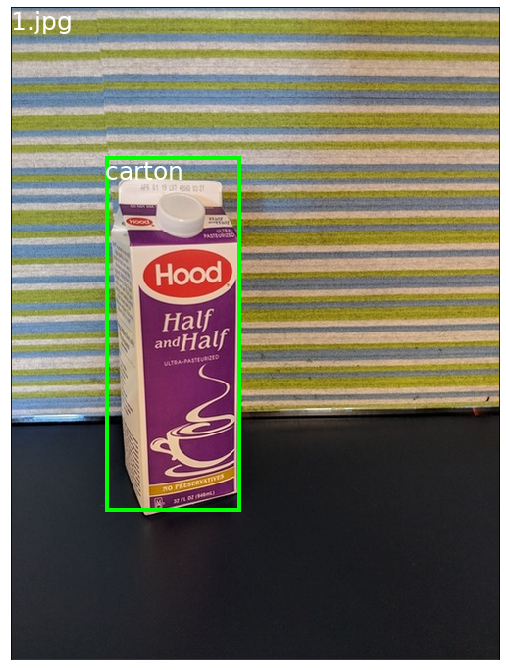

In [99]:
display_bboxes(
    ims[0],
    rand_im_paths[0],
    plot_settings=PlotSettings(rect_color=(0, 255, 0)),
)

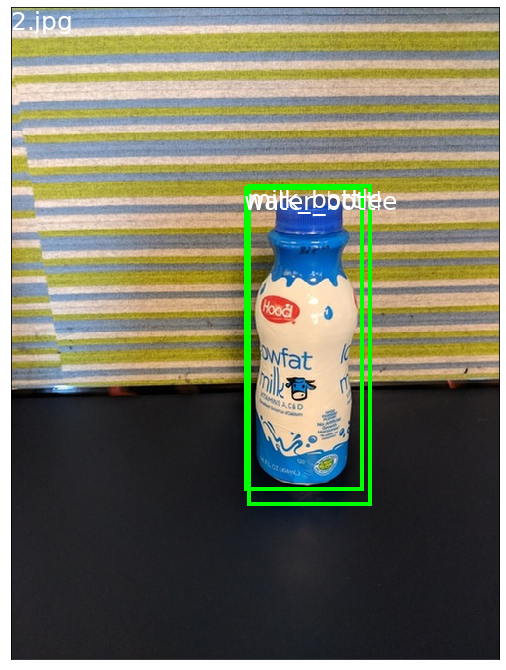

In [101]:
display_bboxes(
    ims[1],
    rand_im_paths[1],
    plot_settings=PlotSettings(rect_color=(0, 255, 0)),
)

# Concluding Remarks
This notebook show one way you might want to deploy your model. Of course, there are many other ways of doing this. You may want to deploy on an edge (IoT) device, or just deploy another type of compute platform (not Kubernetes). But this should give you a sense of what the process looks like.